In [2]:
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM
from scripts.inference import inference_once
from scripts.inference_batch import inference_batch
from tqdm import tqdm

[2024-05-30 19:48:34,335] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# model_path = "mtgv/MobileVLM-1.7B" # MobileVLM
# model_path = "mtgv/MobileVLM_V2-1.7B" # MobileVLM V2
model_path = "output/mobilevlm-2.finetune" # MobileVLM V2
image_file = "data/finetune_data/coco/train2014/COCO_train2014_000000581857.jpg"
prompt_str = "Detect blue shirt and say its coordinates."
# (or) What is the title of this book?
# (or) Is this book related to Education & Teaching?

args = type('Args', (), {
    "model_path": model_path,
    "image_file": image_file,
    "prompt": prompt_str,
    "conv_mode": "v1",
    "temperature": 0, 
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512,
    "load_8bit": False,
    "load_4bit": False,
})()

ans = inference_once(args)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
/media/hdd/anoskov/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/media/hdd/anoskov/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this

In [3]:
ans

'Coordinates are 24, 55, 46, 74.'

In [4]:
import pandas as pd
val_data = pd.read_json('data/finetune_data/refcocogp_in_llava_format_test.json')
val_data.head()

,id,image,conversations
0,581563,coco/train2014/COCO_train2014_000000581563.jpg,"[{'from': 'human', 'value': '<image> Detect lo..."
1,581563,coco/train2014/COCO_train2014_000000581563.jpg,"[{'from': 'human', 'value': '<image> Detect bp..."
2,581563,coco/train2014/COCO_train2014_000000581563.jpg,"[{'from': 'human', 'value': '<image> Detect bl..."
3,581563,coco/train2014/COCO_train2014_000000581563.jpg,"[{'from': 'human', 'value': '<image> Detect ta..."
4,581563,coco/train2014/COCO_train2014_000000581563.jpg,"[{'from': 'human', 'value': '<image> Detect th..."


In [5]:
len(val_data)

30903

In [6]:
val_data.iloc[0]['conversations']

[{'from': 'human',
  'value': '<image>\nDetect lower left corner darkness and say its coordinates.'},
 {'from': 'gpt', 'value': 'Coordinates are 0, 41, 74, 100.'}]

In [7]:
val_data.iloc[0]['conversations'][1]['value'].split()[2:]

['0,', '41,', '74,', '100.']

In [8]:
coords = [list() for i in range(len(val_data))]
for idx, row in val_data.iterrows():
    coord = row['conversations'][1]['value'].split()[2:]
    coord = [float(x[:-1]) for x in coord]
    coords[idx] = coord

In [9]:
val_data['coords'] = coords

In [10]:
val_data['image'] = val_data['image'].apply(lambda x: 'data/finetune_data/' + x)

In [11]:
val_data['questions'] = val_data['conversations'].apply(lambda x: x[0]['value'][8:])

In [12]:
val_data

,id,image,conversations,coords,questions
0,581563,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect lo...","[0.0, 41.0, 74.0, 100.0]",Detect lower left corner darkness and say its ...
1,581563,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect bp...","[0.0, 41.0, 74.0, 100.0]",Detect bpttom left dark and say its coordinates.
2,581563,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect bl...","[0.0, 41.0, 74.0, 100.0]",Detect black van in front of cab and say its c...
3,581563,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect ta...","[16.0, 100.0, 76.0, 100.0]",Detect taxi and say its coordinates.
4,581563,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect th...","[16.0, 100.0, 76.0, 100.0]",Detect the taxi cab bottom right and say its c...
...,...,...,...,...,...
30898,53643,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect pe...","[32.0, 91.0, 15.0, 71.0]",Detect person wearing floral shirt and say its...
30899,302199,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect a ...","[42.0, 63.0, 14.0, 156.0]",Detect a guy in black jacket and cowboy hat an...
30900,302199,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect th...","[42.0, 63.0, 14.0, 156.0]",Detect the man in the dark coat and pointier h...
30901,573297,data/finetune_data/coco/train2014/COCO_train20...,"[{'from': 'human', 'value': '<image> Detect a ...","[27.0, 89.0, 12.0, 93.0]",Detect a person in red dress and he is seeing ...


In [13]:
def get_iou(bb1, bb2):
    # Taken from https://stackoverflow.com/a/42874377
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    # assert bb1['x1'] < bb1['x2']
    # assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [23]:
val_data.iloc[0]['conversations'][0]['value'][8:]

'Detect lower left corner darkness and say its coordinates.'

In [14]:
model_path = "output/mobilevlm-2.finetune" # MobileVLM V2

args = type('Args', (), {
        "model_path": model_path,
        "image_file": val_data['image'][:10000],
        "prompt": val_data['questions'][:10000],
        "conv_mode": "v1",
        "temperature": 0, 
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 512,
        "load_8bit": False,
        "load_4bit": False,
    })()
answers_10k = inference_batch(args)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
  0%|          | 0/10000 [00:00<?, ?it/s]/media/hdd/anoskov/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/media/hdd/anoskov/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. 

In [18]:
# input coords in format [x1, x2, y1, y2]
def cvt_coords(coords):
    res = dict()
    res['x1'] = coords[0]
    res['x2'] = coords[1]
    res['y1'] = coords[2]
    res['y2'] = coords[3]
    return res

In [20]:

ious = [0 for i in range(10000)]

for idx in range(len(answers_10k)):
    ref_coords = val_data.iloc[idx]['coords']
    ref_coords = cvt_coords(ref_coords)
    # prompt_str = row['conversations'][0]['value'][8:]
    # image_file = 'data/finetune_data/' + row['image']
    # args = type('Args', (), {
    #     "model_path": model_path,
    #     "image_file": image_file,
    #     "prompt": prompt_str,
    #     "conv_mode": "v1",
    #     "temperature": 0, 
    #     "top_p": None,
    #     "num_beams": 1,
    #     "max_new_tokens": 512,
    #     "load_8bit": False,
    #     "load_4bit": False,
    # })()
    ans = answers_10k[idx]
    try:
        pred_coord = [float(x[:-1]) for x in ans.split()[2:]]
        pred_coord = cvt_coords(pred_coord)
        ious[idx] = get_iou(ref_coords, pred_coord)
    except:
        ious[idx] = 0

In [21]:
ious

[0.5703564727954972,
 0.6904315196998124,
 0.27331887201735355,
 0.6412213740458015,
 0.6220238095238095,
 0.6412213740458015,
 0.5856164383561644,
 0.5018341892883346,
 0.5856164383561644,
 0.10764872521246459,
 0.13252148997134672,
 0.2,
 0.8241308793456033,
 0.8241308793456033,
 0.8428290766208252,
 0.937841043890866,
 0.9396244354647016,
 0.9672131147540983,
 0.9090909090909091,
 0.8936043036461446,
 0.680640243902439,
 0.7331189710610932,
 0.7051397655545536,
 0.7961904761904762,
 0.7557251908396947,
 0.7424511545293073,
 0.5355303810504635,
 0.0,
 0.9065934065934066,
 0.638733705772812,
 0.8799102132435466,
 0.5157593123209169,
 0.5239988639591026,
 0.644,
 0.3166001140901312,
 0.027411167512690356,
 0.35338822039265355,
 0.16307541625857003,
 0.10628426824124843,
 0.3273381294964029,
 0.5143884892086331,
 0.49634146341463414,
 0.8860439956725568,
 0.8860439956725568,
 0.853227551388388,
 0.8620689655172413,
 0.8928571428571429,
 0.9615384615384616,
 0.031647689216342936,
 0.6038

In [22]:
import numpy as np
mAP_70 = [1.0 if x >= 0.7 else 0 for x in ious]
np.mean(mAP_70), np.mean(ious)

(0.7434632221557691, 0.5773007556219861)

In [23]:
len(ious)

10000

In [28]:
with open('answers_10k.log', 'w') as f:
    for i in ious:
        f.write(f'{i}\n')

In [60]:
mAP_70

[0.4803368954219085,
 1.0,
 1.0,
 0.28838128036123983,
 0.3776780916980619,
 0.28838128036123983,
 1.0,
 0.6180459568662384,
 0.49588532574411737,
 0.2152964838292366,
 0.32145285314909433,
 0.21367275985149295,
 0.4757779619313489,
 0.47635626760088584,
 0.6442000416705351,
 0.5881179018108318,
 0.5135460378921265,
 0.6606016917267864,
 0.5906723169060727,
 0.5895453819822211,
 0.6546723456790124,
 0.1907400843779533,
 0.13901926925868763,
 0.13901926925868763,
 1.0,
 1.0,
 1.0,
 0.6779254125311163,
 1.0,
 0.441256025336968,
 0.441256025336968,
 0.6585036399303882,
 0.6583149054215406,
 0.5436032852364517,
 1.0,
 0.35171972786015326,
 1.0,
 0.1627110938429775,
 0.16132421426785698,
 0.18976500882337022,
 0.6618984507168455,
 1.0,
 0.648762110206763,
 0.5554005940302141,
 0.21538863363773852,
 0.5428685068175538,
 0.4371347119857215,
 0.4230091541543846,
 0.4230091541543846,
 0.5833418335679574,
 0.5833418335679574,
 0.6432208191133051,
 0.44922125795079276,
 0.09208953917072547,
 0.20

In [2]:
from PIL import Image

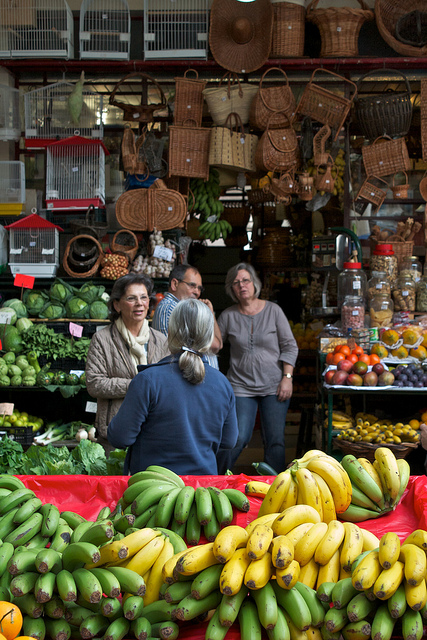

In [7]:
Image.open("data/finetune_data/coco/train2014/COCO_train2014_000000581857.jpg").convert("RGB")